# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Loading libraries</b>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Sequential


# For Model Building
import tensorflow as tf
import keras
import zipfile


### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/capstone/cell_images.zip'
# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Define image dimensions (e.g., 64x64 pixels) and channels (3 for RGB, 1 for grayscale)
img_width, img_height = 64, 64
channels = 3


train_data_dir = '/content/cell_images/train'
test_data_dir = '/content/cell_images/test'




train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()


train_generator = train_datagen.flow_from_directory(
    train_data_dir ,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False)



Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


###<b> Check the shape of train and test images

---



In [ ]:
print("Training set (images) shape:", (train_generator.samples, img_width, img_height, channels))
print("Testing set (images) shape:", (test_generator.samples, img_width, img_height, channels))


Training set (images) shape: (24958, 64, 64, 3)
Testing set (images) shape: (2600, 64, 64, 3)


###<b> Check the shape of train and test labels

In [ ]:
print("Shape of train labels for each batch :", train_generator[0][1].shape)
print("Total number of training samples:", train_generator.samples)
print("Total number of testing samples:", test_generator.samples)

number_of_classes_training = len(train_generator.class_indices)
number_of_classes_testing = len(test_generator.class_indices)


print("Total shape of training :", (train_generator.samples,number_of_classes_training))
print("Total shape of testing :", (test_generator.samples, number_of_classes_testing ))



Shape of train labels for each batch : (32,)
Total number of training samples: 24958
Total number of testing samples: 2600
Total shape of training : (24958, 2)
Total shape of testing : (2600, 2)


####<b> Observations and insights:
The dataset comprises 24,958 training samples and 2,600 testing samples, each with 2 features. This indicates a substantial training set size compared to the testing set, suitable for model training, while ensuring enough test data for evaluation. The identical feature dimension (2) in both sets suggests consistency in data structure for straightforward model application.


### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
def find_min_max_from_generator(generator):
    min_val, max_val = 255, 0  # Initialize with the maximum and minimum possible values for 8-bit images
    for images, _ in generator:
        min_val = min(min_val, images.min())
        max_val = max(max_val, images.max())
        break  # Only check the first batch; remove this line to check the entire dataset
    return min_val, max_val

# Calculate min and max pixel values for the training set
min_train, max_train = find_min_max_from_generator(train_generator)
# Calculate min and max pixel values for the testing set
min_test, max_test = find_min_max_from_generator(test_generator)

print(f"Training Images - Min Pixel Value: {min_train}, Max Pixel Value: {max_train}")
print(f"Testing Images - Min Pixel Value: {min_test}, Max Pixel Value: {max_test}")



Training Images - Min Pixel Value: 0.0, Max Pixel Value: 237.0
Testing Images - Min Pixel Value: 0.0, Max Pixel Value: 227.0


####<b> Observations and insights:
The dataset shows training images with pixel values ranging from 0.0 to 230.0, and testing images ranging from 0.0 to 227.0. The presence of 0.0 as the minimum value in both sets indicates black pixels, while the slight difference in maximum values suggests a minor variance in brightness or exposure between the training and testing sets. This highlights the need for normalization to ensure model consistency and suggests potential preprocessing adjustments for handling brightness variations.



###<b> Count the number of values in both uninfected and parasitized

In [ ]:
def count_categories_efficiently(generator, total_samples):
    # Initialize counters for each category
    count_uninfected, count_parasitized = 0, 0

    # Calculate the number of batches to process
    batches_to_process = max(1, total_samples // generator.batch_size)

    # Process each batch
    for _ in range(batches_to_process):
        _, labels = next(generator)
        # Update counts based on labels
        count_uninfected += (labels == 0).sum()
        count_parasitized += (labels == 1).sum()

    return count_uninfected, count_parasitized


total_samples_test = len(test_generator.filenames)  # Total number of test samples
count_uninfected_test, count_parasitized_test = count_categories_efficiently(test_generator, total_samples_test)

print(f"Testing - Uninfected: {count_uninfected_test}, Parasitized: {count_parasitized_test}")


Testing - Uninfected: 1268, Parasitized: 1300


###<b>Normalize the images

In [ ]:
def normalize_images_from_generator(generator):
    # This function will yield batches of images normalized to the range [0, 1] and their associated labels
    for images, labels in generator:
        # Normalize images to [0, 1] by dividing by 255
        images_normalized = images / 255.0
        yield (images_normalized, labels)

# Create a normalized generator for both training and testing datasets
normalized_train_generator = normalize_images_from_generator(train_generator)
normalized_test_generator = normalize_images_from_generator(test_generator)



####<b> Observations and insights: _____

###<b> Plot to check if the data is balanced

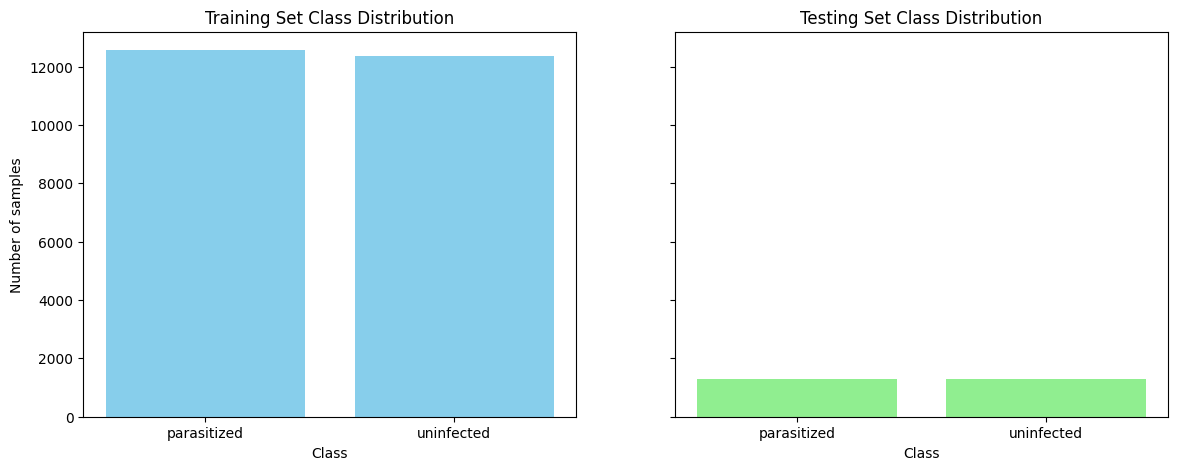

In [ ]:
import matplotlib.pyplot as plt

def count_categories_efficiently(generator, class_indices):
    # Initialize counters for each category
    counts = {class_label: 0 for class_label in class_indices}
    total_samples = len(generator.filenames)
    batches_to_process = max(1, total_samples // generator.batch_size)

    for _ in range(batches_to_process):
        _, labels = next(generator)
        for label in labels:
            class_label = list(class_indices.keys())[int(label)]
            counts[class_label] += 1

    # Reset the generator to avoid issues with generator state
    generator.reset()

    return counts

# Extract class labels and counts from the training generator
train_classes = train_generator.class_indices
train_counts = count_categories_efficiently(train_generator, train_classes)

# Extract class labels and counts from the testing generator
test_classes = test_generator.class_indices
test_counts = count_categories_efficiently(test_generator, test_classes)

# Combine the counts into a list for plotting
train_values = list(train_counts.values())
test_values = list(test_counts.values())
classes = list(train_classes.keys())

# Plotting the class distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
ax[0].bar(classes, train_values, color='skyblue')
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of samples')

ax[1].bar(classes, test_values, color='lightgreen')
ax[1].set_title('Testing Set Class Distribution')
ax[1].set_xlabel('Class')

plt.show()


####<b> Observations and insights: _____

### <b>Data Exploration</b>
Let's visualize the images from the train data

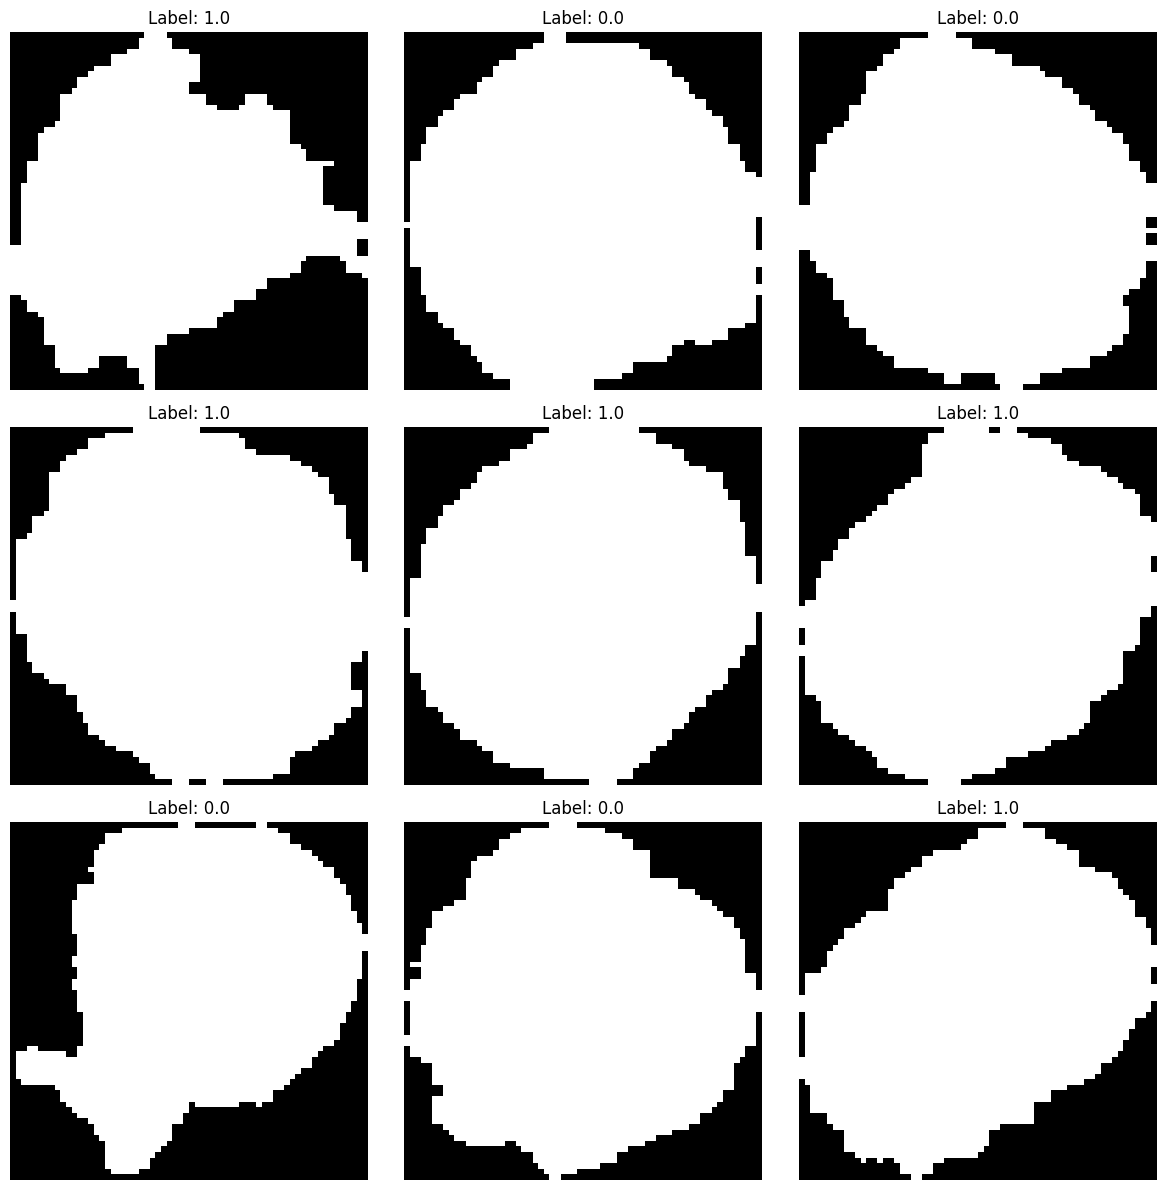

In [ ]:
import matplotlib.pyplot as plt

def plot_images_from_generator(generator, num_images=9):
    """
    Plots a grid of `num_images` from the provided generator.
    Args:
    - generator: A Python generator that yields tuples of (images, labels).
    - num_images: Total number of images to display. Defaults to 9. Should be a perfect square for a neat grid.
    """

    # Extract a batch from the generator
    images, labels = next(generator)

    # Determine the grid size
    grid_size = int(num_images ** 0.5)

    # Set up the plot
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_images):
        # Plot the images
        ax = axes[i]
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        # Set the title to the label of the image
        ax.set_title(f"Label: {labels[i]}")

    plt.tight_layout()
    plt.show()

plot_images_from_generator(train_generator, num_images=9)


####<b> Observations and insights: _____

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

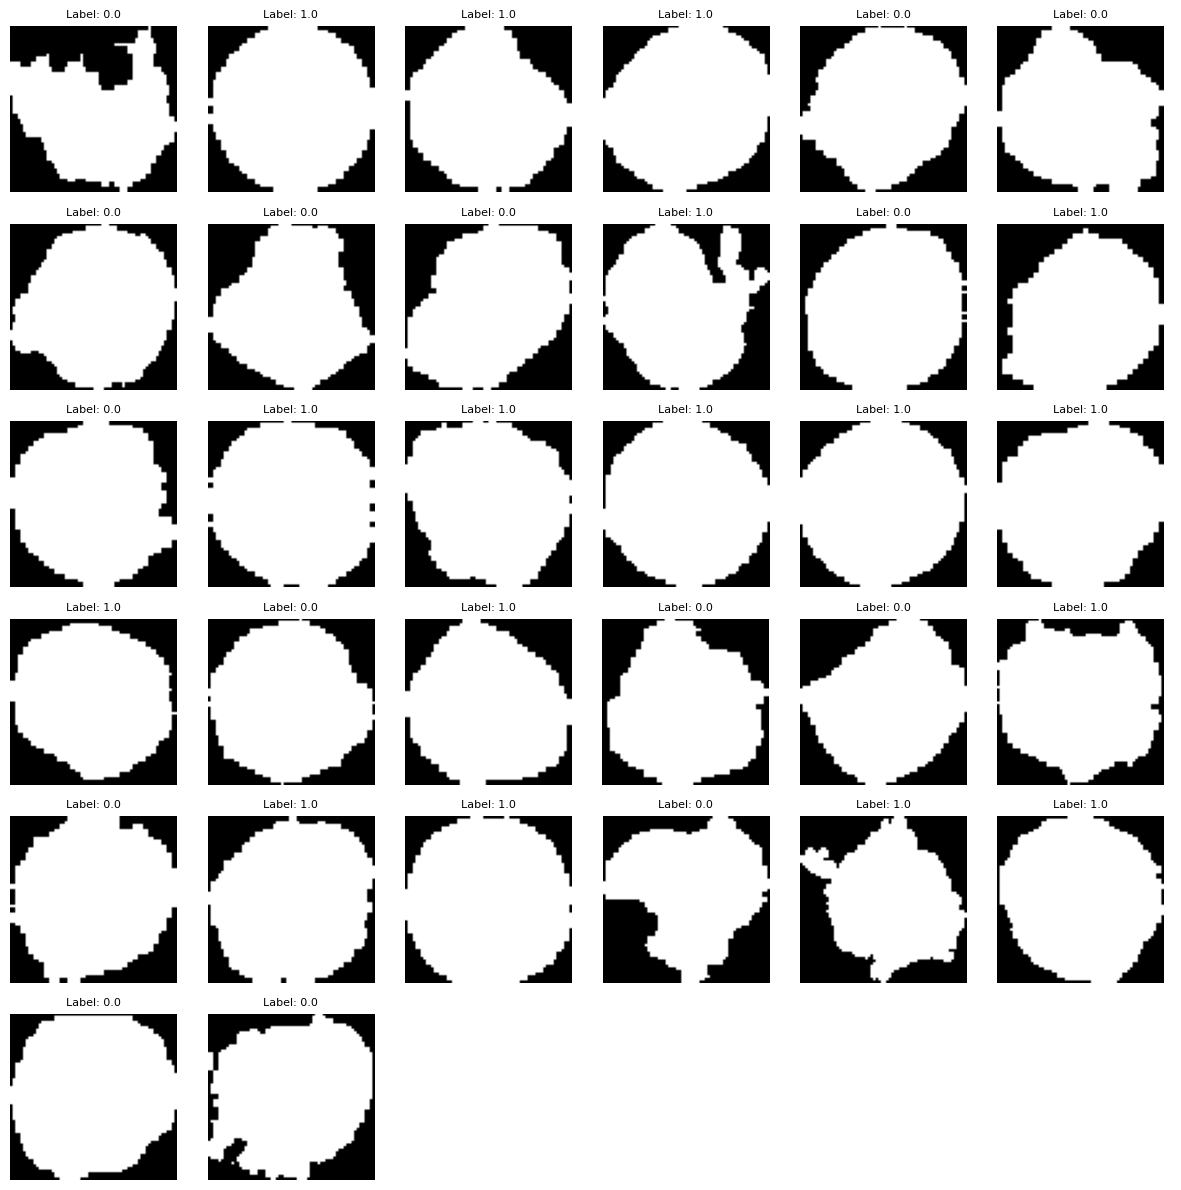

In [ ]:
import matplotlib.pyplot as plt

def plot_images_from_generator_6x6(generator):
    """
    Plots a 6x6 grid of images from the provided generator with a figsize of (12, 12).
    Args:
    - generator: A Python generator that yields tuples of (images, labels).
    """

    # Extract a batch from the generator
    images, labels = next(generator)

    # Set up the plot
    fig, axes = plt.subplots(6, 6, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(36):  # Since we're plotting 6x6 images
        # Plot the images
        ax = axes[i]
        if i < len(images):  # Check to make sure we do not go out of bounds
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')
            # Set the title to the label of the image
            ax.set_title(f"Label: {labels[i]}", fontsize=8)
        else:
            ax.axis('off')  # Hide axes if no image is available to plot

    plt.tight_layout()
    plt.show()


plot_images_from_generator_6x6(train_generator)




####<b>Observations and insights:

###<b> Plotting the mean images for parasitized and uninfected

<b> Mean image for parasitized

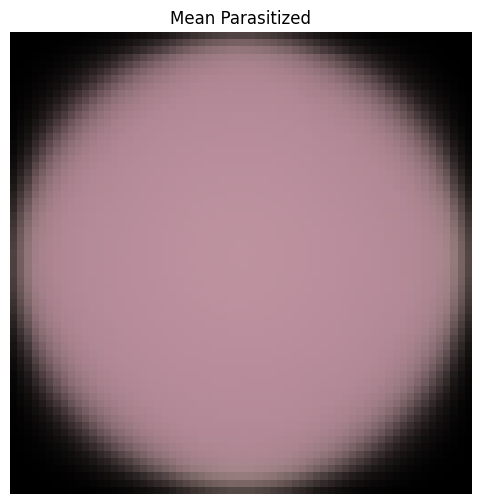

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_mean_image(generator, class_label, img_height, img_width, channels):
    """Compute the mean image for a given class label."""
    sum_image = np.zeros((img_height, img_width, channels), dtype=np.float32)
    sample_count = 0

    # Ensure the generator is starting from the beginning
    generator.reset()

    for images, labels in generator:
        # Filter images by class label
        class_images = images[np.where(labels == generator.class_indices[class_label])]
        sum_image += np.sum(class_images, axis=0)
        sample_count += class_images.shape[0]

        # Break if all samples have been processed
        if sample_count >= len(generator.filenames) / len(generator.class_indices):
            break

    mean_image = sum_image / sample_count
    return mean_image

# Compute the mean image for "parasitized"
parasitized_mean_image = compute_mean_image(train_generator, 'parasitized', img_height, img_width, channels)

# Plot the mean image for "parasitized"
plt.figure(figsize=(6, 6))
plt.imshow(parasitized_mean_image.astype('uint8'))
plt.title('Mean Parasitized')
plt.axis('off')
plt.show()


 Mean image for uninfected

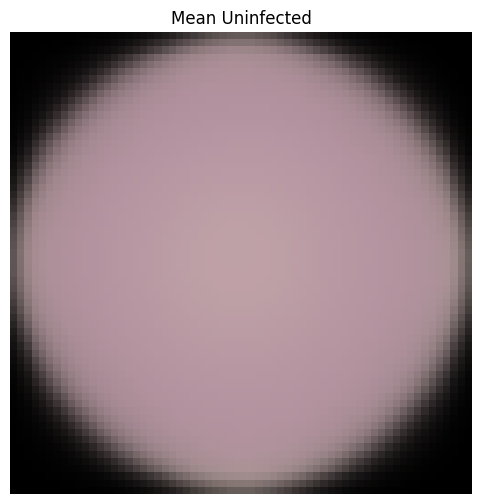

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def compute_mean_image(generator, class_label, img_height, img_width, channels):
    """Compute the mean image for a given class label."""
    sum_image = np.zeros((img_height, img_width, channels), dtype=np.float32)
    sample_count = 0

    # Ensure the generator is starting from the beginning
    generator.reset()

    for images, labels in generator:
        # Filter images by class label
        class_images = images[np.where(labels == generator.class_indices[class_label])]
        sum_image += np.sum(class_images, axis=0)
        sample_count += class_images.shape[0]

        # Break if all samples have been processed
        if sample_count >= len(generator.filenames) / len(generator.class_indices):
            break

    mean_image = sum_image / sample_count
    return mean_image

# Compute the mean image for "uninfected"
uninfected_mean_image = compute_mean_image(train_generator, 'uninfected', img_height, img_width, channels)

# Plot the mean image for "uninfected"
plt.figure(figsize=(6, 6))
plt.imshow(uninfected_mean_image.astype('uint8'))
plt.title('Mean Uninfected')
plt.axis('off')
plt.show()




####<b> Observations and insights:
The mean images for "uninfected" and "parasitized" cells show central brightness, indicating cell concentration in the middle. The "Mean Uninfected" image appears more uniform, suggesting consistent cell characteristics. The "Mean Parasitized" image has more edge variation, hinting at irregularities associated with infection. These differences could be useful for classification in automated diagnosis systems.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def rgb_to_hsv(image):
    """
    Convert an RGB image to HSV.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Define a new ImageDataGenerator with the RGB to HSV conversion as a preprocessing function
train_datagen = ImageDataGenerator(
    preprocessing_function=rgb_to_hsv  # Apply the custom preprocessing
)


train_data_dir = '/content/cell_images/train'

# Create a generator that will read data from the directory
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Now, when we use train_generator, the images will be automatically converted to HSV as they are loaded


Found 24958 images belonging to 2 classes.


###<b> Converting the test data

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def rgb_to_hsv(image):
    """
    Convert an RGB image to HSV.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Define a new ImageDataGenerator with the RGB to HSV conversion as a preprocessing function for the test data
test_datagen = ImageDataGenerator(
    preprocessing_function=rgb_to_hsv  # Apply the custom preprocessing
)

test_data_dir = '/content/cell_images/test'

# Create a generator that will read data from the directory
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Typically we don't shuffle data for evaluation/testing
)

# Now, when we use test_generator, the images will be automatically converted to HSV as they are loaded


Found 2600 images belonging to 2 classes.


####<b>Observations and insights: _____

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def apply_gaussian_blur(image):
    """
    Apply Gaussian blur to an image.
    The (5, 5) defines the kernel size over which the effect takes place.
    """
    return cv2.GaussianBlur(image, (5, 5), 0)

# Define a new ImageDataGenerator with the Gaussian blur as a preprocessing function
train_datagen = ImageDataGenerator(
    preprocessing_function=apply_gaussian_blur  # Apply the custom preprocessing
)


# Create a generator that will read data from the directory and apply the preprocessing function
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Now, when we use train_generator, the images will have Gaussian blur applied as they are loaded


Found 24958 images belonging to 2 classes.


###<b> Gaussian Blurring on test data

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def apply_gaussian_blur(image):
    """
    Apply Gaussian blur to an image.
    The (5, 5) defines the kernel size over which the effect takes place.
    """
    return cv2.GaussianBlur(image, (5, 5), 0)

# Define a new ImageDataGenerator with the Gaussian blur as a preprocessing function for the test data
test_datagen = ImageDataGenerator(
    preprocessing_function=apply_gaussian_blur  # Apply the custom preprocessing
)



# Create a generator that will read data from the directory and apply Gaussian blurring
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# When we use test_generator, the images will have Gaussian blur applied as they are loaded


Found 2600 images belonging to 2 classes.


####**Observations and insights:
Observations and insights:
Applying Gaussian blurring smooths the image, potentially reducing noise and small details. For medical imaging, this could help a model focus on larger structures rather than noise, but it may also obscure important diagnostic features.

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

Blurring might help if overfitting to noise is an issue, but it could hinder performance if fine details are crucial for classification. Other techniques to try include edge detection (to highlight cell boundaries), contrast enhancement (to make features more distinct), or data augmentation (to improve generalization). The choice depends on the specific characteristics of the cells and the diagnostic criteria used by experts.

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


####<B>One Hot Encoding the train and test labels

In [ ]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',  # Change to 'categorical' for one-hot encoding
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',  # Change to 'categorical' for one-hot encoding
    shuffle=False)


Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


###<b> Building the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation

# Define the model
model = Sequential()

# Convolutional layer with 32 filters, a kernel size of 3x3, input shape defined by image dimensions
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, channels)))
model.add(Activation('relu'))
# Max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a second convolutional layer with 64 filters
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
# Max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a third convolutional layer with 128 filters
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
# Max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to convert the 2D matrices to a 1D vector
model.add(Flatten())
# Fully connected layer with 64 units
model.add(Dense(64))
model.add(Activation('relu'))
# Dropout to prevent overfitting
model.add(Dropout(0.5))
# Output layer with a single neuron since it's binary classification, using sigmoid activation function
model.add(Dense(1))
model.add(Activation('sigmoid'))



###<b> Compiling the model

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                   

<b> Using Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the callbacks

# ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'model_best.h5',  # Path where to save the model
    monitor='val_loss',  # The metric to monitor
    save_best_only=True,  # Save only the best model
    verbose=1  # Logging level
)

# EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=10,  # How many epochs to wait before stopping
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric.
)

# ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # The metric to monitor
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1
)




<b> Fit and train our Model

In [ ]:
# Number of epochs to train for
epochs = 20

# Fit the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback],
    verbose=1
)

Epoch 1/20
779/780 [============================>.] - ETA: 0s - loss: 0.8870 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.69315, saving model to model_best.h5
780/780 [==============================] - 36s 38ms/step - loss: 0.8867 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
  3/780 [..............................] - ETA: 23s - loss: 0.6931 - accuracy: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


780/780 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.69315 to 0.69315, saving model to model_best.h5
780/780 [==============================] - 28s 36ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
780/780 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 3: val_loss did not improve from 0.69315
780/780 [==============================] - 29s 37ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
780/780 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 4: val_loss did not improve from 0.69315
780/780 [==============================] - 29s 37ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
779/780 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 5: val_

###<b> Evaluating the model on test data

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


82/82 [==============================] - 6s 76ms/step - loss: 0.6931 - accuracy: 0.5000
Test Loss: 0.6931467652320862
Test Accuracy: 0.5


<b> Plotting the confusion matrix

82/82 [==============================] - 4s 51ms/step


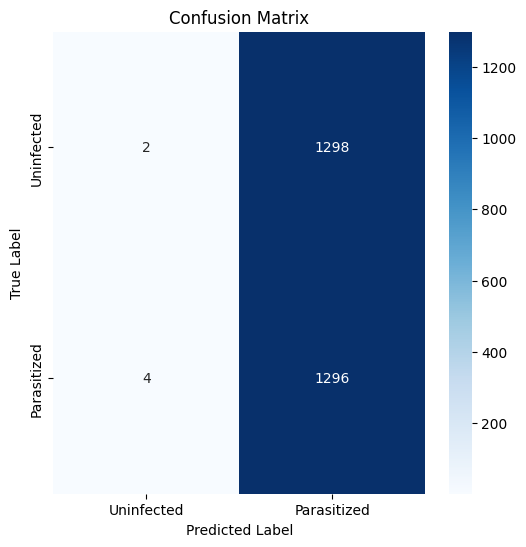

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the test set
test_generator.reset()  # Resetting the generator to ensure proper ordering
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


<b>Plotting the train and validation curves

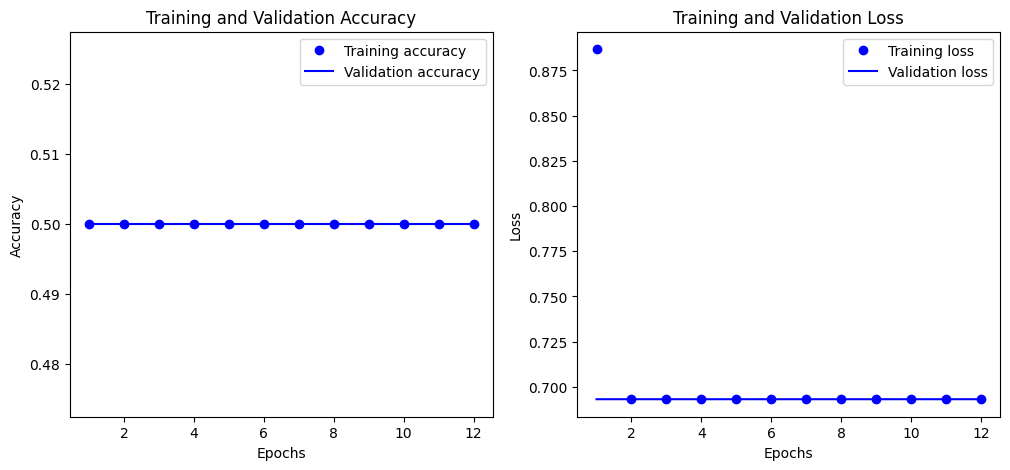

In [ ]:
# Plotting the training and validation accuracy and loss at each epoch
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


###<b> Building the Model

In [ ]:
model_1 = Sequential()

# First Convolutional Block
model_1.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, channels)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model_1.add(Conv2D(64, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model_1.add(Conv2D(128, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model_1.add(Conv2D(256, (3, 3)))
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening followed by Dense Layers
model_1.add(Flatten())
model_1.add(Dense(128))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))

# Output Layer
model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))




###<b> Compiling the model

In [ ]:
# Compile the model
model_1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Model Summary
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 activation_5 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 activation_6 (Activation)   (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                 

<b> Using Callbacks

In [ ]:
checkpoint_callback_1 = ModelCheckpoint(
    'model_1_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_callback_1 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr_callback_1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1
)

callbacks_1 = [checkpoint_callback_1, early_stopping_callback_1, reduce_lr_callback_1]


<b>Fit and Train the model

In [ ]:
history_1 = model_1.fit(
    train_generator,
    epochs=20,# colab gpu limte usage
    validation_data=test_generator,
    callbacks=callbacks_1,
    verbose=1
)


Epoch 1/20
779/780 [============================>.] - ETA: 0s - loss: 0.3794 - accuracy: 0.8225
Epoch 1: val_loss improved from inf to 0.06098, saving model to model_1_best.h5
780/780 [==============================] - 46s 49ms/step - loss: 0.3790 - accuracy: 0.8227 - val_loss: 0.0610 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 2/20
  1/780 [..............................] - ETA: 46s - loss: 0.0586 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


780/780 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9708
Epoch 2: val_loss improved from 0.06098 to 0.05512, saving model to model_1_best.h5
780/780 [==============================] - 36s 46ms/step - loss: 0.0975 - accuracy: 0.9708 - val_loss: 0.0551 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 3/20
779/780 [============================>.] - ETA: 0s - loss: 0.0781 - accuracy: 0.9762
Epoch 3: val_loss improved from 0.05512 to 0.05264, saving model to model_1_best.h5
780/780 [==============================] - 37s 47ms/step - loss: 0.0783 - accuracy: 0.9762 - val_loss: 0.0526 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 4/20
780/780 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9775
Epoch 4: val_loss did not improve from 0.05264
780/780 [==============================] - 37s 48ms/step - loss: 0.0756 - accuracy: 0.9775 - val_loss: 0.0737 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 5/20
780/780 [==============================] - ETA: 0s - loss: 

###<b> Evaluating the model

In [ ]:
test_loss_1, test_accuracy_1 = model_1.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss_1}")
print(f"Test Accuracy: {test_accuracy_1}")


82/82 [==============================] - 3s 39ms/step - loss: 0.0496 - accuracy: 0.9862
Test Loss: 0.04955732449889183
Test Accuracy: 0.9861538410186768


<b> Plotting the confusion matrix

82/82 [==============================] - 3s 37ms/step


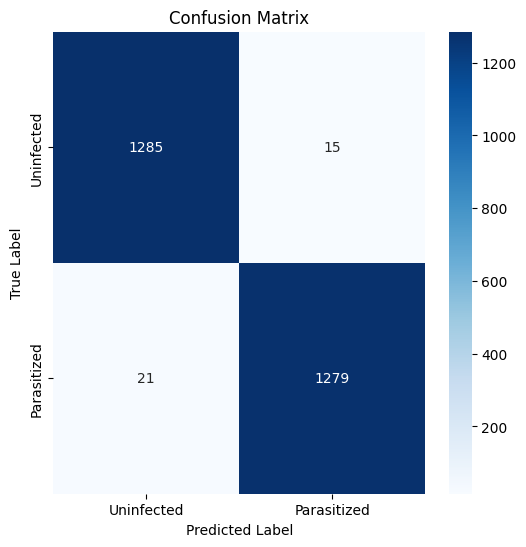

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions_1 = model_1.predict(test_generator)
predicted_classes_1 = np.where(predictions_1 > 0.5, 1, 0).flatten()
true_classes_1 = test_generator.classes
cm_1 = confusion_matrix(true_classes_1, predicted_classes_1)

plt.figure(figsize=(6, 6))
sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues", xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


<b> Plotting the train and the validation curves

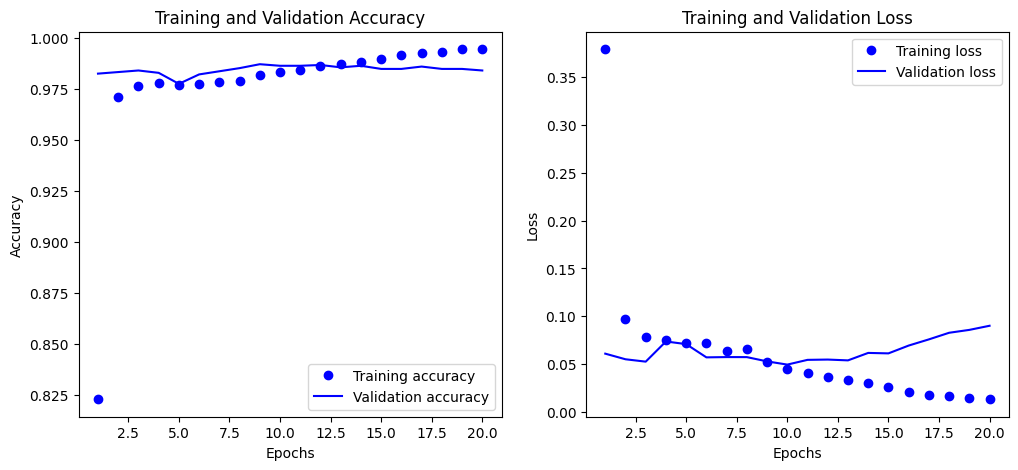

In [ ]:
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_1 = range(1, len(acc_1) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_1, acc_1, 'bo', label='Training accuracy')
plt.plot(epochs_1, val_acc_1, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_1, loss_1, 'bo', label='Training loss')
plt.plot(epochs_1, val_loss_1, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

###<b> Building the Model

In [ ]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

model_2 = Sequential()

# First Convolutional Block with Batch Normalization and LeakyReLU
model_2.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, channels)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block with Batch Normalization and LeakyReLU
model_2.add(Conv2D(64, (3, 3)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block with Batch Normalization and LeakyReLU
model_2.add(Conv2D(128, (3, 3)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block with Batch Normalization and LeakyReLU
model_2.add(Conv2D(256, (3, 3)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening followed by Dense Layers with Batch Normalization and LeakyReLU
model_2.add(Flatten())
model_2.add(Dense(128))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(Dropout(0.5))
model_2.add(Dense(64))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(Dropout(0.5))

# Output Layer
model_2.add(Dense(1, activation='sigmoid'))

###<b>Compiling the model

In [ ]:
model_2.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])


<b> Using callbacks

In [ ]:
checkpoint_callback_2 = ModelCheckpoint(
    'model_2_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_callback_2 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr_callback_2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1
)

callbacks_2 = [checkpoint_callback_2, early_stopping_callback_2, reduce_lr_callback_2]


<b>Fit and train the model

In [ ]:
history_2 = model_2.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks_2,
    verbose=1
)


Epoch 1/10
780/780 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.9237
Epoch 1: val_loss improved from inf to 0.07272, saving model to model_2_best.h5
780/780 [==============================] - 46s 49ms/step - loss: 0.1962 - accuracy: 0.9237 - val_loss: 0.0727 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 2/10
  1/780 [..............................] - ETA: 45s - loss: 0.0379 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


779/780 [============================>.] - ETA: 0s - loss: 0.0911 - accuracy: 0.9709
Epoch 2: val_loss improved from 0.07272 to 0.05618, saving model to model_2_best.h5
780/780 [==============================] - 39s 51ms/step - loss: 0.0913 - accuracy: 0.9708 - val_loss: 0.0562 - val_accuracy: 0.9808 - lr: 0.0010
Epoch 3/10
780/780 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9742
Epoch 3: val_loss did not improve from 0.05618
780/780 [==============================] - 38s 49ms/step - loss: 0.0827 - accuracy: 0.9742 - val_loss: 0.1204 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 4/10
780/780 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9764
Epoch 4: val_loss improved from 0.05618 to 0.04873, saving model to model_2_best.h5
780/780 [==============================] - 38s 48ms/step - loss: 0.0751 - accuracy: 0.9764 - val_loss: 0.0487 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 5/10
780/780 [==============================] - ETA: 0s - loss: 

<b>Plotting the train and validation accuracy

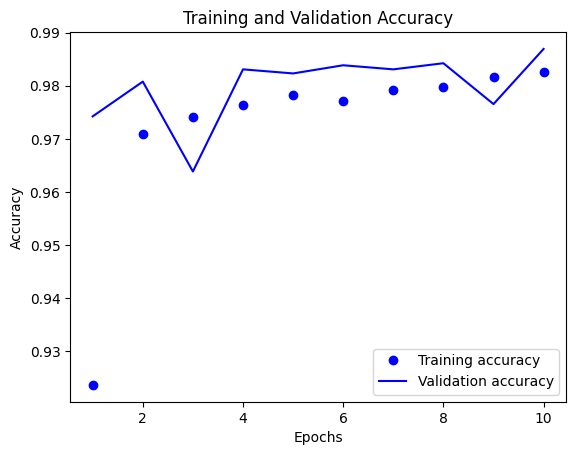

In [ ]:

acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']

epochs_2 = range(1, len(acc_2) + 1)

plt.plot(epochs_2, acc_2, 'bo', label='Training accuracy')
plt.plot(epochs_2, val_acc_2, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


###<b>Evaluating the model

In [ ]:
test_loss_2, test_accuracy_2 = model_2.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss_2}")
print(f"Test Accuracy: {test_accuracy_2}")


82/82 [==============================] - 4s 51ms/step - loss: 0.0430 - accuracy: 0.9869
Test Loss: 0.043023768812417984
Test Accuracy: 0.986923098564148


####<b>Observations and insights:
The two models exhibit closely matched performance, with test accuracies around 98.69% and 98.62%, and test losses of approximately 0.043 and 0.050, respectively. The first model demonstrates slightly superior precision and reliability due to its lower test loss, despite the marginal difference in accuracy. Both models show strong generalization capabilities to unseen data, indicating robust performance.

<b> Generate the classification report and confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predictions
test_generator.reset()  # Ensure the generator is reset to the beginning
predictions_2 = model_2.predict(test_generator)
predicted_classes_2 = np.where(predictions_2 > 0.5, 1, 0).flatten()

# True labels
true_classes_2 = test_generator.classes

# Confusion Matrix
cm_2 = confusion_matrix(true_classes_2, predicted_classes_2)
print('Confusion Matrix:')
print(cm_2)

# Classification Report
print('Classification Report:')
target_names = ['Uninfected', 'Parasitized']
print(classification_report(true_classes_2, predicted_classes_2, target_names=target_names))


82/82 [==============================] - 3s 39ms/step
Confusion Matrix:
[[1284   16]
 [  18 1282]]
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.99      0.99      0.99      1300
 Parasitized       0.99      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

###<b> Use image data generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
train_datagen_3 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No data augmentation for test data
test_datagen_3 = ImageDataGenerator(rescale=1./255)

# Create data generators for train and test data with data augmentation
train_generator_3 = train_datagen_3.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

test_generator_3 = test_datagen_3.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)


Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.
Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

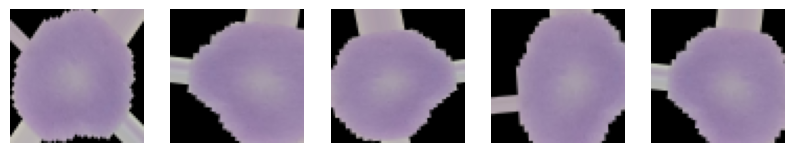

In [ ]:
# Generate augmented images and plot them
augmented_images = [train_generator_3[0][0][0] for i in range(5)]  # Generate 5 augmented images

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()


####<b>Observations and insights: ____
The augmented images show variations in orientation and perspective, indicating a typical data augmentation technique used to enhance model generalization by simulating different viewing conditions while preserving key features of the original image.


###<b>Building the Model

In [ ]:
model_3 = Sequential([
    Conv2D(32, (3, 3), input_shape=(img_width, img_height, channels)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])

model_3.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model_3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 activation_12 (Activation)  (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 activation_13 (Activation)  (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                

<b>Using Callbacks

In [ ]:
checkpoint_callback_3 = ModelCheckpoint(
    'model_3_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_callback_3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr_callback_3 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1
)

callbacks_3 = [checkpoint_callback_3, early_stopping_callback_3, reduce_lr_callback_3]


<b> Fit and Train the model

In [ ]:
history_3 = model_3.fit(
    train_generator_3,
    epochs=10,
    validation_data=test_generator_3,
    callbacks=callbacks_3,
    verbose=1
)


Epoch 1/10
780/780 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9549
Epoch 1: val_loss did not improve from 0.04456
780/780 [==============================] - 85s 109ms/step - loss: 0.1376 - accuracy: 0.9549 - val_loss: 0.0447 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 2/10
780/780 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9560
Epoch 2: val_loss did not improve from 0.04456
780/780 [==============================] - 69s 89ms/step - loss: 0.1385 - accuracy: 0.9560 - val_loss: 0.0569 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 3/10
780/780 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9552
Epoch 3: val_loss did not improve from 0.04456
780/780 [==============================] - 83s 106ms/step - loss: 0.1361 - accuracy: 0.9552 - val_loss: 0.0468 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 4/10
780/780 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9565
Epoch 4: val_loss did not improve f

###<B>Evaluating the model

<b>Plot the train and validation accuracy

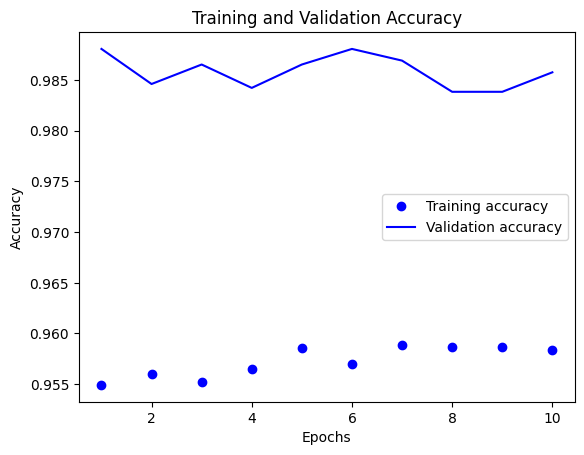

In [ ]:
acc_3 = history_3.history['accuracy']
val_acc_3 = history_3.history['val_accuracy']
epochs_3 = range(1, len(acc_3) + 1)

plt.plot(epochs_3, acc_3, 'bo', label='Training accuracy')
plt.plot(epochs_3, val_acc_3, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


<B>Plotting the classification report and confusion matrix

In [ ]:
from sklearn.metrics import classification_report

# Predictions
test_generator_3.reset()  # Ensure the generator is reset to the beginning
predictions_3 = model_3.predict(test_generator_3)
predicted_classes_3 = np.where(predictions_3 > 0.5, 1, 0).flatten()

# True labels
true_classes_3 = test_generator_3.classes

# Classification Report
print('Classification Report:')
target_names = ['Uninfected', 'Parasitized']
print(classification_report(true_classes_3, predicted_classes_3, target_names=target_names))

# Confusion Matrix
cm_3 = confusion_matrix(true_classes_3, predicted_classes_3)
print('Confusion Matrix:')
print(cm_3)


82/82 [==============================] - 4s 48ms/step
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.51      0.52      0.52      1300
 Parasitized       0.52      0.51      0.51      1300

    accuracy                           0.52      2600
   macro avg       0.52      0.52      0.51      2600
weighted avg       0.52      0.52      0.51      2600

Confusion Matrix:
[[677 623]
 [638 662]]


<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load the pre-trained VGG16 model without the fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, channels))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add new fully connected layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)




58889256/58889256 [==============================] - 0s 0us/step


###<b>Compiling the model

In [ ]:
# Create the new model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_vgg16.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

<b> using callbacks

In [ ]:
checkpoint_callback_vgg16 = ModelCheckpoint(
    'model_vgg16_best.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_callback_vgg16 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr_callback_vgg16 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1
)

callbacks_vgg16 = [checkpoint_callback_vgg16, early_stopping_callback_vgg16, reduce_lr_callback_vgg16]


<b>Fit and Train the model

In [ ]:
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks_vgg16,
    verbose=1
)


Epoch 1/10
779/780 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9389
Epoch 1: val_loss improved from inf to 0.13087, saving model to model_vgg16_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


780/780 [==============================] - 51s 59ms/step - loss: 0.1917 - accuracy: 0.9389 - val_loss: 0.1309 - val_accuracy: 0.9512 - lr: 0.0010
Epoch 2/10
779/780 [============================>.] - ETA: 0s - loss: 0.1103 - accuracy: 0.9606
Epoch 2: val_loss did not improve from 0.13087
780/780 [==============================] - 40s 51ms/step - loss: 0.1103 - accuracy: 0.9606 - val_loss: 0.1554 - val_accuracy: 0.9392 - lr: 0.0010
Epoch 3/10
779/780 [============================>.] - ETA: 0s - loss: 0.0965 - accuracy: 0.9640
Epoch 3: val_loss improved from 0.13087 to 0.10480, saving model to model_vgg16_best.h5
780/780 [==============================] - 39s 50ms/step - loss: 0.0965 - accuracy: 0.9640 - val_loss: 0.1048 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 4/10
780/780 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9692
Epoch 4: val_loss improved from 0.10480 to 0.10219, saving model to model_vgg16_best.h5
780/780 [==============================] - 39s 49ms

<b>Plot the train and validation accuracy

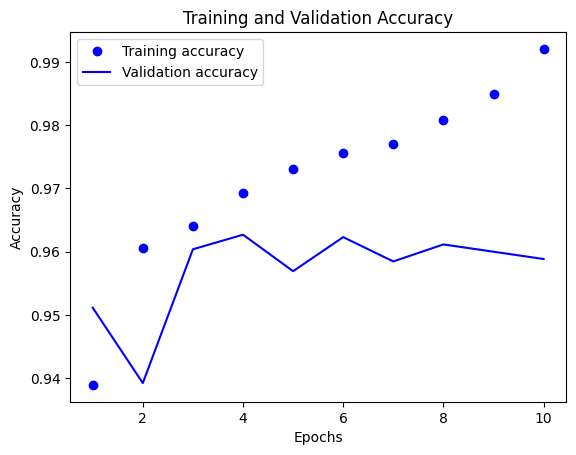

In [ ]:
acc_vgg16 = history_vgg16.history['accuracy']
val_acc_vgg16 = history_vgg16.history['val_accuracy']
epochs_vgg16 = range(1, len(acc_vgg16) + 1)

plt.plot(epochs_vgg16, acc_vgg16, 'bo', label='Training accuracy')
plt.plot(epochs_vgg16, val_acc_vgg16, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


###**Observations and insights: _____**

*   What can be observed from the validation and train curves?
The validation accuracy is consistently lower than the training accuracy, which could indicate overfitting. Both accuracies improve over epochs, but the gap suggests the model may not generalize as well to unseen data.

###<b> Evaluating the model

In [ ]:

test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss_vgg16}")
print(f"Test Accuracy: {test_accuracy_vgg16}")


82/82 [==============================] - 4s 48ms/step - loss: 0.1407 - accuracy: 0.9588
Test Loss: 0.14069148898124695
Test Accuracy: 0.9588461518287659


<b>Plotting the classification report and confusion matrix

In [ ]:
from sklearn.metrics import classification_report

# Predictions
test_generator.reset()  # Ensure the generator is reset to the beginning
predictions_vgg16 = model_vgg16.predict(test_generator)
predicted_classes_vgg16 = np.where(predictions_vgg16 > 0.5, 1, 0).flatten()

# True labels
true_classes_vgg16 = test_generator.classes

# Classification Report
print('Classification Report:')
target_names = ['Uninfected', 'Parasitized']
print(classification_report(true_classes_vgg16, predicted_classes_vgg16, target_names=target_names))

# Confusion Matrix
cm_vgg16 = confusion_matrix(true_classes_vgg16, predicted_classes_vgg16)
print('Confusion Matrix:')
print(cm_vgg16)


82/82 [==============================] - 3s 40ms/step
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.95      0.97      0.96      1300
 Parasitized       0.97      0.95      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600

Confusion Matrix:
[[1262   38]
 [  69 1231]]


###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?

The model shows balanced high performance with similar precision, recall, and F1-scores for both 'Uninfected' and 'Parasitized' categories. The confusion matrix reveals a small bias: the model is more prone to falsely classifying 'Parasitized' as 'Uninfected' than vice versa.

*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


In [ ]:
best_model=model_3

best_model.save('/content/drive/My Drive/final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


####<b> Observations and Conclusions drawn from the final model: _____



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?







*  You can try to build a model using these HSV images and compare them with your other models.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?

Model Performance Improvement:
Exploring pre-trained models or alternate CNN architectures could enhance model_3's performance, especially if it struggles with complex feature extraction.

Using HSV Images:
Testing model_3 with HSV images may provide insights into color feature relevance and potentially boost performance .

Most Meaningful Insights:
For model_3, insights would focus on which layers and neurons activate for certain features, helping to understand the model's decision-making process.

Comparison of Techniques:
Comparing model_3's performance with other techniques would rely on metrics like accuracy and loss. Techniques yielding better metrics or requiring fewer resources could be preferred.

Proposal for Final Solution Design:
Model_3, with appropriate tuning and validation, could be proposed if it shows superior performance and generalization over alternatives, considering the trade-off between accuracy and computational cost.